In [1]:
!pip install import_ipynb

In [2]:
try:
    import google.colab  # noqa: F401
except ImportError:
    import dolfin
else:
    try:
        import dolfin
    except ImportError:
        !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
        import dolfin

import numpy as np
import matplotlib.pyplot as plt
import mshr
import fenics as fe

In [3]:
from google.colab import drive
drive.mount('/content/drive')
import os
import import_ipynb

path = '/content/drive/MyDrive/Colab Notebooks/Physics-Informed Neural Networks/Demo/fenics_cfd/generate_data'
os.chdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from vessel_geometry import generate_vessel_geometry
from boundaries import define_boundaries
from navier_stokes import solve_navier_stokes
from visualize_geometry import visualize

importing Jupyter notebook from vessel_geometry.ipynb
importing Jupyter notebook from boundaries.ipynb
importing Jupyter notebook from navier_stokes.ipynb
importing Jupyter notebook from visualize_geometry.ipynb


In [5]:
def to_meters(size):
  return size * 10**(-6)

In [6]:
def get_inflow_profile(height, max_velocity):
  inflow_profile = (f'4 * {max_velocity} * x[1] / {height} * (1 - x[1] / {height})', '0')     # inflow velocity min: 500 micrometers/sec, max: 1800 micrometers/sec
  return inflow_profile

In [7]:
def define_function_spaces(mesh):
  V = fe.VectorFunctionSpace(mesh, 'P', 2)
  Q = fe.FunctionSpace(mesh, 'P', 1)

  return V, Q

In [20]:
T = 1.0                   # final time
num_steps = 1501          # number of time steps
dt = T / num_steps        # time step size
mu_scalar = 0.0035        # dynamic viscosity
rho_scalar = 1060         # density

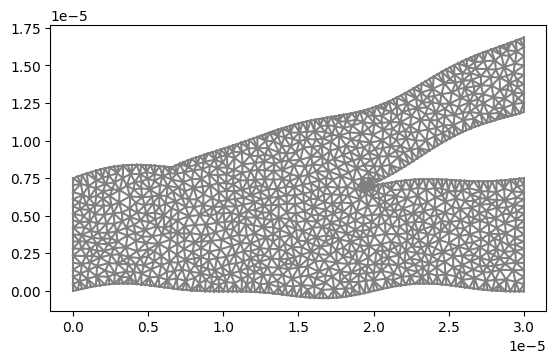

In [18]:
target_resolution = 32
length, height = 30, 7.5  # height min: 5 micrometers, max: 10 micrometers

vessel_params = {
    'healthy': {
        'undulation_amplitude': to_meters(height/40), # min: height/150,      max: height/25
        'undulation_frequency': 3,                    # min: 1,               max: 3
        'oscilations': 3                              # min: 2,               max: 6
    },
    'isthmus': {
        'isthmus_height': to_meters(height/3.75),     # min: height/3.75,     max: height/2.3
        'isthmus_width': to_meters(length/15),        # min: length/15,       max: length/4
        'isthmus_position': to_meters(length/2),      # min: isthmus_width,   max: length - isthmus_width
        'undulation_amplitude': to_meters(height/20), # min: height/40,       max: height/20
        'undulation_frequency': 1.5                   # min: 1,               max: 2
    },
    'branch': {
        'branch_width': to_meters(height),            # min: height/1.5,        max: height
        'branch_angle':np.pi/8,                       # min: np.pi/8,         max: np.pi/4
        'branch_position_x': to_meters(length/10),    # min: 0,               max: length/3
        'undulation_amplitude': to_meters(height/40), # min: height/40,       max: height/20
        'undulation_frequency': 3,                    # min: 1,               max: 3
        'oscilations': 3                              # min: 2,               max: 5
    },
    'aneurysm': {
        'aneurysm_width': to_meters(height/1.5),      # min: height/1.5,      max: height/1.1
        'aneurysm_height': to_meters(height/3.75),    # min: height/3.75,     max: height/1.5
        'aneurysm_strecth': to_meters(height/5),      # min: 0,               max: height/2.5
        'aneurysm_intake': to_meters(height/15),      # min: height/15,       max: height/3.75
        'aneurysm_roundness': to_meters(height/0.75), # min: height,          max: height/0.75
        'aneurysm_center': to_meters(height/1.5),     # min: aneurysm_width,  max: length - aneurysm_width
        'undulation_amplitude': to_meters(height/40), # min: height/40,       max: height/25
        'undulation_frequency': 3,                    # min: 1,               max: 3
        'oscilations': 3                              # min: 2,               max: 5
    },
}

length, height = to_meters(length), to_meters(height)
domain = generate_vessel_geometry('branch', length=length, height=height, params=vessel_params)

mesh = mshr.generate_mesh(domain, target_resolution)
fe.plot(mesh)

Time step n: 0, Velocity: [0.00003, 0.00120], Pressure: [0.00000, 0.00002]
Time step n: 500, Velocity: [0.00002, 0.00135], Pressure: [0.00000, 0.01039]
Time step n: 1000, Velocity: [0.00002, 0.00135], Pressure: [0.00000, 0.02074]
Time step n: 1500, Velocity: [0.00002, 0.00135], Pressure: [0.00000, 0.03109]


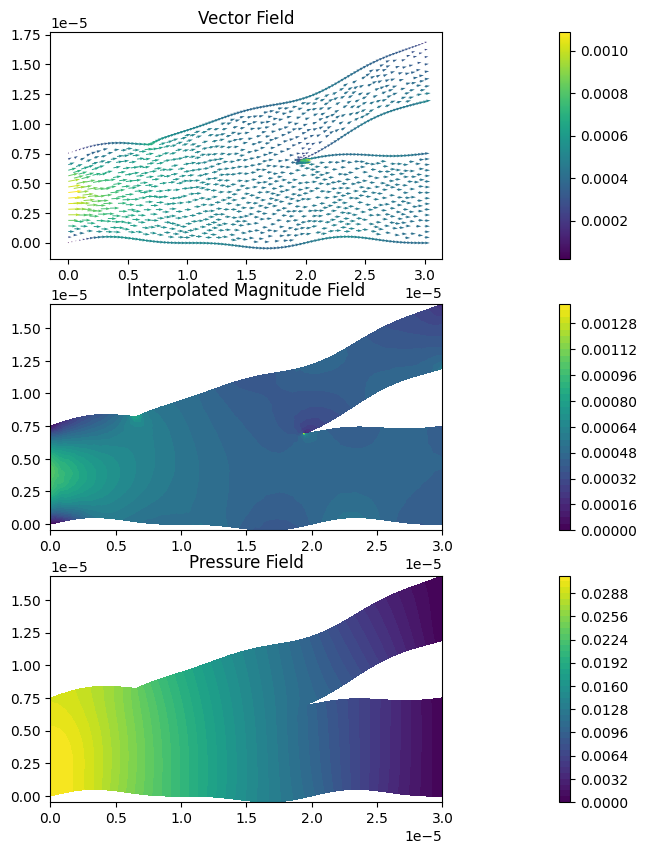

In [21]:
V, Q = define_function_spaces(mesh)
boundaries = define_boundaries(mesh, length, height)
max_velocity = to_meters(1000)
inflow_profile = get_inflow_profile(height, max_velocity)

u_, p_ = solve_navier_stokes(V, Q, mesh, boundaries, inflow_profile, dt, mu_scalar, rho_scalar, num_steps, 'bicgstab')

visualize(u=u_, p=p_)